# Тестовое задание "Предсказание успешности публикации"

---





  Разработать модель для предсказание количество цитирований публикации через 5 лет после момента выхода на тестовых данных. Оценить эффективность работы модели и влияние параметров на качество предсказаний.

  Исходные данные представлены в CSV формате. Каждая строка описывает публикацию, в колонках приведены разные показатели статьи. В колонке с именем "c5" записано искомое количество цитирований статьи через 5 лет после выхода. Именно это значение нужно предсказывать.
Файл с входными данными доступен для скачивания по ссылке:

 https://drive.google.com/file/d/16O04PRpsQrjcc6g_5skcLwOOeayv_xUr/view?usp=sharing

  В качестве решения должен быть предоставлен Jupyter notebook, содержащий код на языке программирования Python для решения поставленной задачи, который можно запустить с помощью команды Cell | Run All. Можно пользоваться всеми публично доступными библиотеками для машинного обучения.

  **Внимание!** Кроме предоставления ноутбука с решением необходимо создать файл для настройки пакетов Python в формате для conda или pip.


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
import warnings
warnings.filterwarnings('ignore')

print('Сейчас нужно будет загрузить файл "predict.csv"')
files.upload()

In [54]:
df_vals = pd.read_csv('predict.csv')
df_vals = df_vals[['recency',	'topic_rank',	'diversity',	'authors_mean_rank',	'authors_mean_hindex',	
         'authors_mean_gindex',	'authors_mean_sociality',	'journal_rank',	
         'title_len',	'abstract_len',	'n_authors',	'c5',	'log_authors_mean_sociality']]

In [55]:
df = df_vals[~df_vals['authors_mean_hindex'].isnull()]
df = df_vals[~df_vals['authors_mean_gindex'].isnull()]
df = df_vals[~df_vals['authors_mean_sociality'].isnull()]
df = df_vals[~df_vals['journal_rank'].isnull()]

**Decision tree**

In [56]:
dff = diversity_target_success = df['diversity']

In [57]:
mean_diversity = 0
mean_diversity = np.mean(dff)

In [58]:
i = 0
for element in dff:
  if ( element < mean_diversity):
    diversity_target_success[i] = 0
  if (element >= mean_diversity):
    diversity_target_success[i] = 1
  i += 1


In [59]:
df['diversity_target_success'] = diversity_target_success

In [60]:
df.to_csv("processedData.csv",index=False)

In [61]:
train = df.head(int(len(df)*0.8))  
test = df.tail(int(len(df)*0.2))

In [62]:
features = list(train.columns[7:10])
x = train[features]
y = train['diversity_target_success']

In [63]:
tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=100, #максимальное число листьев
                              random_state=2021)
clf=tree.fit(x, y)

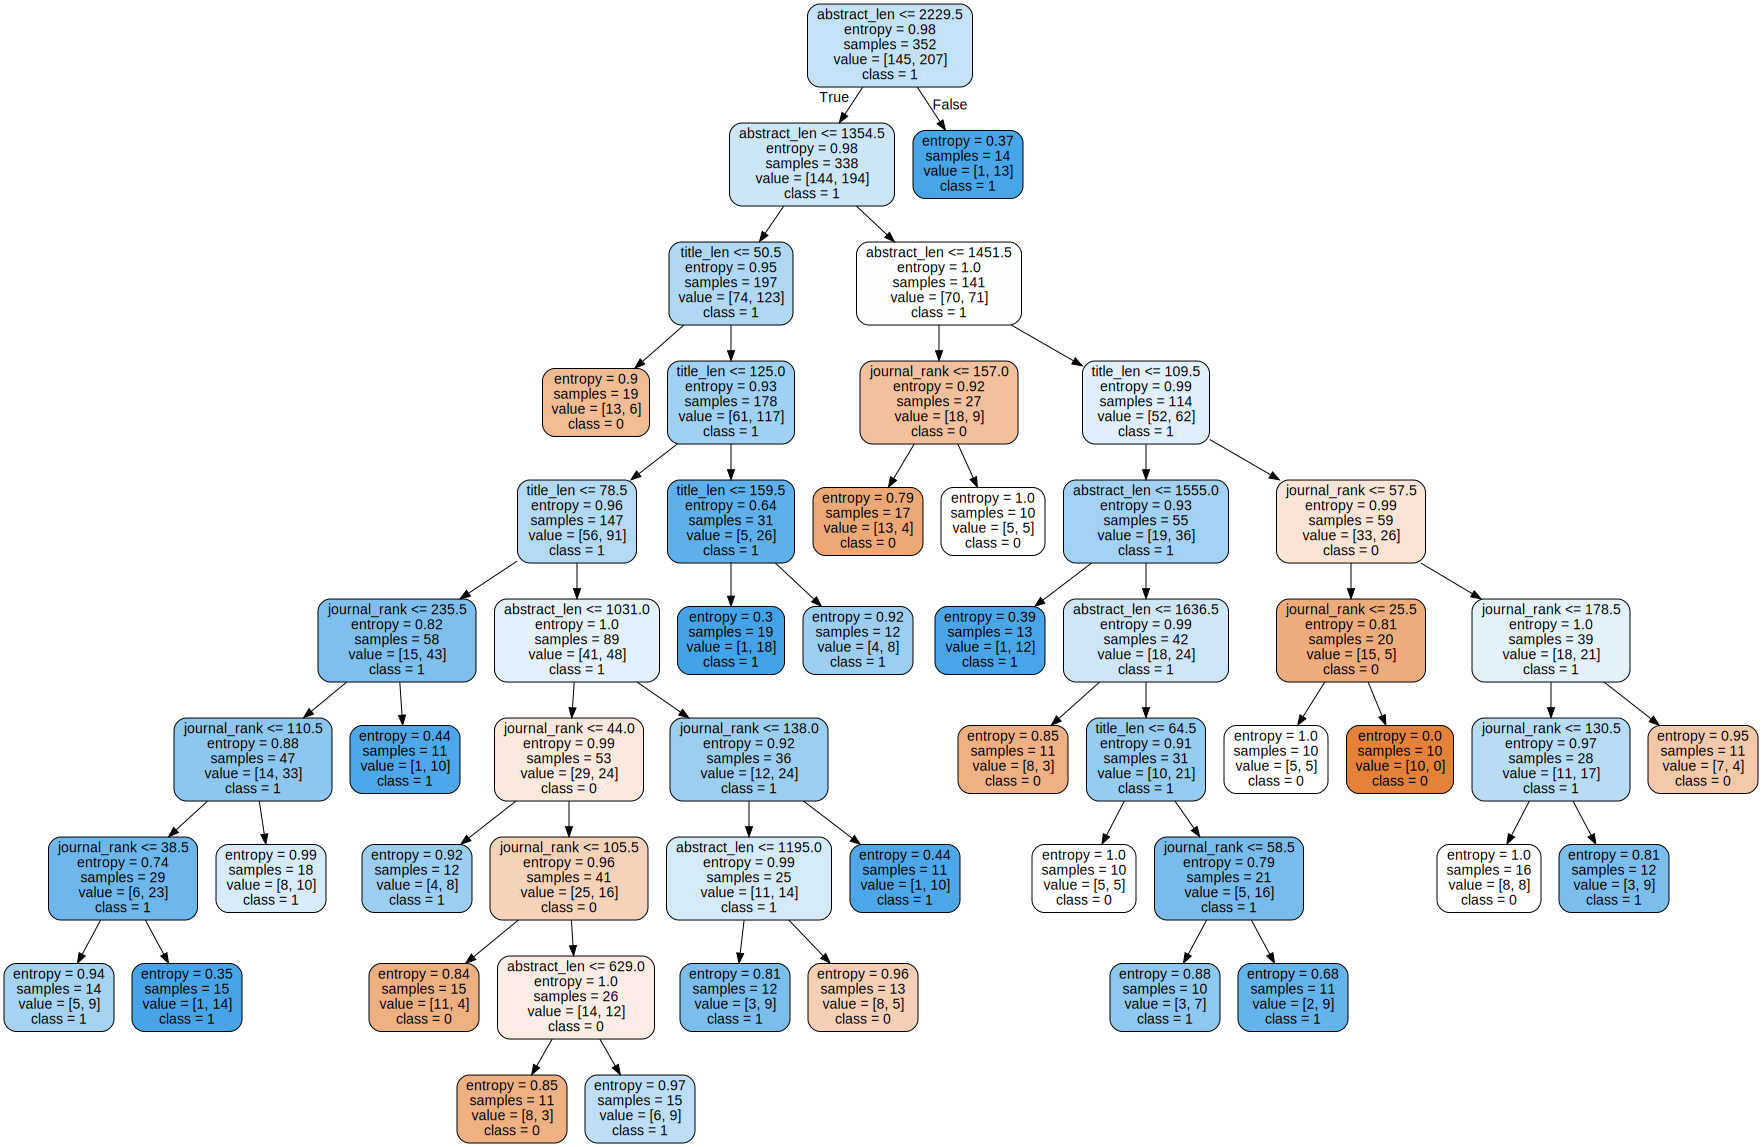

In [64]:
columns = list(x.columns)
export_graphviz(clf, out_file='tree.dot', 
                feature_names=columns,
                class_names=['0', '1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True, label='all')

with open('tree.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

In [65]:
clf.tree_.max_depth

9

In [66]:
features = list(test.columns[7:10])
x = test[features]
y_true = test['diversity_target_success']
y_pred = clf.predict(x)

**Logical regression**

In [67]:
from sklearn.linear_model import LogisticRegression
from google.colab import files
import io
from sklearn import metrics

In [68]:
features = list(train.columns[7:10])
x = train[features]
y = train['diversity_target_success']

In [69]:
#обучение модели
reg = LogisticRegression(random_state=2021, solver='lbfgs').fit(x, y.values.ravel())

In [ ]:
print('Пожалуйста загрузите файл processedData.csv, полученный на предыдущем этапе')
uploaded = files.upload()
uploaded = pd.read_csv(io.BytesIO(uploaded['processedData.csv']), delimiter=',', index_col='diversity_target_success')

In [71]:
publication_for_test = df.loc[1,:].to_frame().T
result = reg.predict_proba(publication_for_test.drop(['recency',	'topic_rank',	'diversity',	'authors_mean_rank',	'authors_mean_hindex',	
         		'title_len', 'diversity_target_success',	'abstract_len',	'n_authors',	'c5',	'log_authors_mean_sociality'], axis=1))

print('publication 1')
print('Unsuccess -', round(result[0][0], 3))
print('Success -', round(result[0][1], 3))

publication 1
Unsuccess - 0.498
Success - 0.502


In [72]:
xTest = pd.DataFrame(publication_for_test.drop(['diversity_target_success'], axis=1))
yPred = reg.predict(xTest.drop(['recency',	'topic_rank',	'diversity',	'authors_mean_rank',	'authors_mean_hindex',	
         		'title_len', 'abstract_len',	'n_authors',	'c5',	'log_authors_mean_sociality'], axis=1))
yTrue = (publication_for_test['diversity_target_success'].to_frame().T).values.ravel()
recall = metrics.recall_score(yTrue, yPred)
precision = metrics.precision_score(yTrue, yPred)
print('Recall:', round(recall, 3))
print('Precision:', round(precision, 3))

Recall: 1.0
Precision: 1.0
